Abgabe von: Mat.Nr.: 9452857 & 1113800

Before doing anything installing all needed dependencies

# Software requirements

Python 3.9–3.11

!pip3 install pandas
!pip3 install scikit-learn
#!pip3 install tensorflow==2.14.1 windows only
!pip3 install tensorflow
!pip3 install scikeras
!pip3 install matplotlib

# Aufgabe 1

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

Import data

In [2]:
white_raw = pd.read_csv(os.getcwd() + "/dataset/winequality-white.csv", delimiter=";")
red_raw = pd.read_csv(os.getcwd() + "/dataset/winequality-red.csv", delimiter=";")

In [3]:
white_raw

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


Split wine in Test and Training Data (75% / 25%)

In [4]:
white_training_Data, white_test_data, white_training_scores, white_test_scores = (train_test_split(white_raw.drop("quality", axis=1), white_raw['quality'],test_size=0.25, random_state=39))

red_training_Data, red_test_data, red_training_scores, red_test_scores = (train_test_split(red_raw.drop("quality", axis=1), red_raw['quality'],test_size=0.25, random_state=39))

In [5]:
white_training_Data = np.array(white_training_Data)
red_training_Data = np.array(red_training_Data)

In [6]:
white_training_Data

array([[ 7.3 ,  0.38,  0.23, ...,  3.1 ,  0.55, 11.2 ],
       [ 6.3 ,  0.33,  0.2 , ...,  3.14,  0.51,  8.8 ],
       [ 7.4 ,  0.41,  0.66, ...,  3.05,  0.46,  8.7 ],
       ...,
       [ 7.4 ,  0.2 ,  0.37, ...,  3.03,  0.42,  9.2 ],
       [ 7.3 ,  0.13,  0.32, ...,  3.2 ,  0.35,  9.2 ],
       [ 6.8 ,  0.19,  0.34, ...,  3.25,  0.45, 12.9 ]])

# Aufgabe 3

https://www.tensorflow.org/tutorials/keras/regression#regression_using_a_dnn_and_multiple_inputs

In [7]:
import keras
from keras import layers
import tensorflow as tf
from math import sqrt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error

from scikeras.wrappers import KerasRegressor

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [9]:
def plot_loss(keras_regressor_model):
  plt.plot(keras_regressor_model.history_['loss'], label='loss')
  plt.plot(keras_regressor_model.history_['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Wine Quality Score]')
  plt.legend()
  plt.grid(True)
  plt.show()
  
def plot_metrics(white_test_scores, test_predictions):
    a = plt.axes(aspect='equal')
    plt.scatter(white_test_scores, test_predictions)
    plt.xlabel('True Values [winequality-white]')
    plt.ylabel('Predictions [winequality-white]')
    lims = [0, 10]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    plt.show()

In [10]:
# Function to calculate model and print Bewertungsmetriken
def model_regressor_grid_calculator(estimator: any, param_grid: dict | list,
                               training_data: any, valid_data: any, training_scores: any, valid_scores: any):
    #select the best HyperParameters while using cross-validation for it (cv=5)
    grid_search = GridSearchCV(estimator, param_grid=param_grid, cv=5, scoring="r2")
    grid_search.fit(training_data, training_scores)
    
    print("Beste Hyperparameter: " + str(grid_search.best_params_))
    
    # Select the best model from Grid Search
    optimal_model = grid_search.best_estimator_
    
    # Selected Params
    cv_results = pd.DataFrame(grid_search.cv_results_).loc[grid_search.best_index_]
    
    r2_score_cv = [cv_results['split0_test_score'], 
                   cv_results['split1_test_score'],
                   cv_results['split2_test_score'],
                   ]
    r2_score_cv_mean = cv_results['mean_test_score']
    r2_score_cv_std = cv_results['std_test_score']
    
    print('Cross Validation')
    print(f'- R^2: {r2_score_cv}')
    print(f'- R^2 Durchschnittlicher: {r2_score_cv_mean:.4f}')
    print(f'- R^2 Standardabweichung: {r2_score_cv_std:.4f}')
    print('\r\n')
    
    
    predicted_test_scores = optimal_model.predict(valid_data)
    
    r2_score_test = r2_score(valid_scores, predicted_test_scores)
    rmse_test = sqrt(mean_squared_error(valid_scores, predicted_test_scores))
    mape_test = mean_absolute_percentage_error(valid_scores, predicted_test_scores)
    
    print('Test:')
    print(f'- R^2: {r2_score_test:.4f}')
    print(f'- RMSE: {rmse_test:.2f}')
    print(f'- MAPE: {mape_test:.2%}')
    
    plot_loss(optimal_model)
    plot_metrics(valid_scores, predicted_test_scores)
    
    return cv_results, optimal_model

In [11]:
#input_layer = layers.Input(shape=(11,))
normalizer = layers.Normalization(axis=-1)
#normalizer.adapt(white_training_Data)

In [19]:
def create_model(unit, n_layers):    
    # Konfiguriere die Verteilungsstrategie
    input_layer = layers.Input(shape=(11,))
    model = keras.Sequential([
        input_layer,
        normalizer,
    ])
    for i in range(n_layers):
        local_units = -1*i*(unit/(n_layers+1))+unit
        model.add(layers.Dense(units=int(local_units), activation='relu'))
    model.add(layers.Dense(1))
         
    model.compile(loss=keras.losses.mean_squared_error,
            optimizer=keras.optimizers.Adam(0.001))      
    
    return model

Beste Hyperparameter: {'batch_size': 64, 'epochs': 128, 'model__n_layers': 2, 'model__unit': 18}
Cross Validation
- R^2: [0.3400777614856033, 0.3162903215931052, 0.29503470448414004]
- R^2 Durchschnittlicher: 0.3491
- R^2 Standardabweichung: 0.0419


Test:
- R^2: 0.3184
- RMSE: 0.73
- MAPE: 10.15%


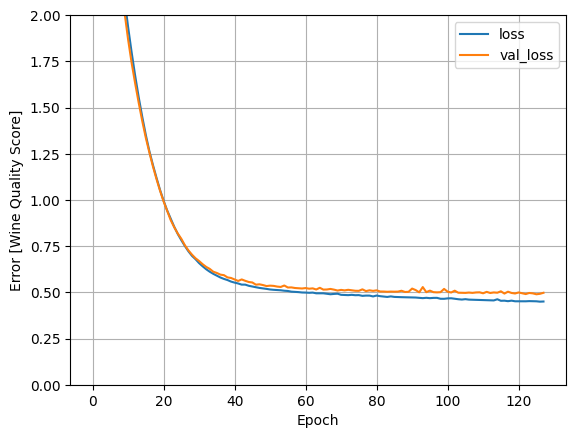

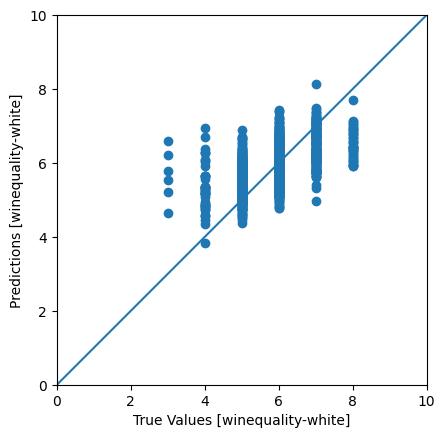

CPU times: total: 12.4 s
Wall time: 41 s


In [53]:
%%time
 #normalizer = layers.Normalization(axis=-1)
normalizer.adapt(white_training_Data)
KerasRegressor_model=KerasRegressor(model=create_model, epochs=32, batch_size=32, model__unit=16, model__n_layers=1, verbose=0, validation_split=0.2)

params={'batch_size':[16, 32, 64],  
        'epochs':[32, 64, 128, 256], 
        'model__unit':[8, 16, 32], 
        'model__n_layers':[1,2,3,7,8],            
} 
best_params={'batch_size':[64],  
        'epochs':[128], 
        'model__unit':[18], 
        'model__n_layers':[2]
} 

cv_results, optimal_model = model_regressor_grid_calculator(KerasRegressor_model, best_params, white_training_Data, white_test_data, white_training_scores, white_test_scores)

In [54]:
optimal_model.model_.summary()

Model: "sequential_197"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 11)                23        
 on)                                                             
                                                                 
 dense_885 (Dense)           (None, 18)                216       
                                                                 
 dense_886 (Dense)           (None, 12)                228       
                                                                 
 dense_887 (Dense)           (None, 1)                 13        
                                                                 
Total params: 480 (1.88 KB)
Trainable params: 457 (1.79 KB)
Non-trainable params: 23 (96.00 Byte)
_________________________________________________________________


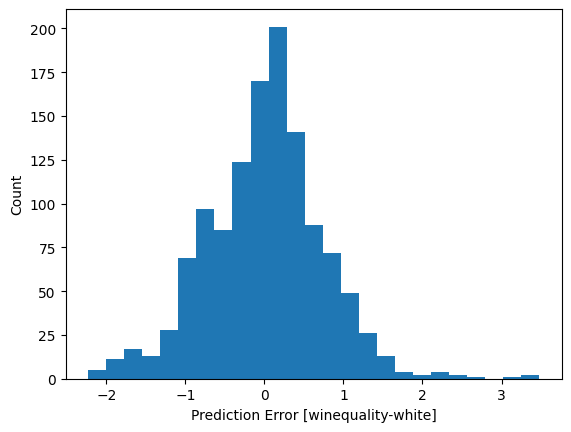

In [17]:
error = test_predictions - white_test_scores
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [winequality-white]')
_ = plt.ylabel('Count')